# Compare MLP and CNN models on FashionMNIST Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import datasets, layers, Model
from keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

2025-12-05 19:01:40.988164: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 19:01:41.059661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/saeed/miniconda3/envs/dl/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
!nvidia-smi

Fri Dec  5 19:01:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   42C    P0              9W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1- Data Preparation

### Load Dataset (FashinMNIST)

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
class_names = {0: 'T-shirt/top',
               1: 'Trouser',
               2: 'Pullover',
               3: 'Dress',
               4: 'Coat',
               5: 'Sandal',
               6: 'Shirt',
               7: 'Sneaker',
               8: 'Bag',
               9: 'Ankle boot'}

### Visualization

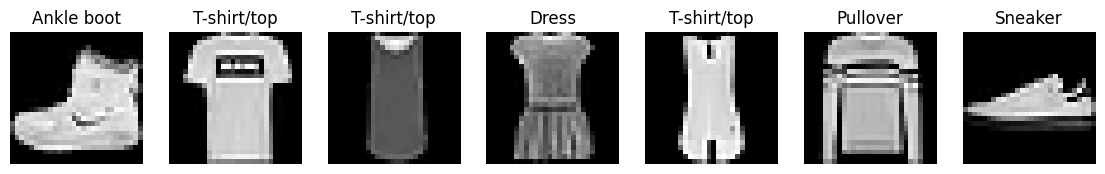

In [6]:
fig, axes = plt.subplots(1, 7, figsize=(14,10))
for i, ax in enumerate(axes):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(class_names[train_labels[i]])
    ax.set_axis_off()

### Pre-processing

In [7]:
# Normalization
X_train = train_images / 255.
X_test = test_images / 255.

In [8]:
X_train_mlp_ = X_train.reshape(-1, 28*28)
X_test_mlp = X_test.reshape(-1, 28*28)

In [9]:
X_train_cnn_ = X_train.reshape(-1, 28, 28, 1)
X_test_cnn = X_test.reshape(-1, 28, 28, 1)

In [10]:
X_train_mlp, X_val_mlp, y_train_mlp, y_val_mlp = train_test_split(X_train_mlp_,
                                                                  train_labels,
                                                                  test_size=0.2,
                                                                  stratify=train_labels)
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn_,
                                                                  train_labels,
                                                                  test_size=0.2,
                                                                  stratify=train_labels)

In [11]:
train_distribution = np.bincount(y_train_mlp)
val_distribution = np.bincount(y_val_mlp)

In [12]:
train_distribution

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [13]:
val_distribution

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

## 2- Model Design

### MLP

In [14]:
inp = layers.Input(shape=(28*28,))
x = layers.Dense(32, activation='relu')(inp)
x = layers.Dense(32, activation='relu')(x)
out = layers.Dense(10, activation='softmax')(x)

model_mlp = Model(inputs=inp, outputs=out)
model_mlp.summary()

I0000 00:00:1764948730.876520    1444 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

### CNN

In [15]:
inp = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(28, 3, activation='relu', padding='same')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
out = layers.Dense(10, activation='softmax')(x)

model_cnn = Model(inputs=inp, outputs=out)
model_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 28)     │         4,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1372)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │        21,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,358 (102.96 KB)

 Trainable params: 26,358 (102.96 KB)

 Non-trainable params: 0 (0.00 B)

## 3- Training

In [16]:
model_mlp.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

### MLP

In [17]:
history_mlp = model_mlp.fit(X_train_mlp, y_train_mlp,
                            epochs=30,
                            batch_size=256,
                            validation_data=(X_val_mlp, y_val_mlp))

Epoch 1/30


2025-12-05 19:02:15.005071: I external/local_xla/xla/service/service.cc:163] XLA service 0x7872d4016ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-05 19:02:15.005173: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-12-05 19:02:15.042947: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-05 19:02:15.238586: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-05 19:02:15.960906: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



 25/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2383 - loss: 2.0683

I0000 00:00:1764948738.803917    1632 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5827 - loss: 1.2147

2025-12-05 19:02:20.767391: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_128', 4 bytes spill stores, 4 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5842 - loss: 1.2104

2025-12-05 19:02:24.173898: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 4 bytes spill stores, 4 bytes spill loads

2025-12-05 19:02:24.225204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 4 bytes spill stores, 4 bytes spill loads

2025-12-05 19:02:24.533207: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 4 bytes spill stores, 4 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.7251 - loss: 0.8108 - val_accuracy: 0.8226 - val_loss: 0.5254
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8327 - loss: 0.4829 - val_accuracy: 0.8374 - val_loss: 0.4623
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8472 - loss: 0.4384 - val_accuracy: 0.8521 - val_loss: 0.4316
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8572 - loss: 0.4132 - val_accuracy: 0.8508 - val_loss: 0.4269
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8626 - loss: 0.3941 - val_accuracy: 0.8610 - val_loss: 0.3979
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8684 - loss: 0.3791 - val_accuracy: 0.8497 - val_loss: 0.4136
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8697 - loss: 0.3713 - val_accuracy: 0.8647 - val_loss: 0.3867
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8751 - loss: 0.3569 - val_accuracy: 0.86

### CNN

In [18]:
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn,
                            epochs=30,
                            batch_size=256,
                            validation_data=(X_val_cnn, y_val_cnn))

Epoch 1/30


2025-12-05 19:03:30.277467: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_251', 4 bytes spill stores, 4 bytes spill loads

2025-12-05 19:03:30.399237: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_251', 4 bytes spill stores, 4 bytes spill loads

2025-12-05 19:03:30.750168: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_470', 8 bytes spill stores, 8 bytes spill loads



183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5939 - loss: 1.1807

2025-12-05 19:03:37.230462: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_251', 4 bytes spill stores, 4 bytes spill loads



188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.7216 - loss: 0.7874 - val_accuracy: 0.8200 - val_loss: 0.5019
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8278 - loss: 0.4723 - val_accuracy: 0.8487 - val_loss: 0.4191
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8534 - loss: 0.4092 - val_accuracy: 0.8486 - val_loss: 0.4158
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8667 - loss: 0.3777 - val_accuracy: 0.8643 - val_loss: 0.3752
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8735 - loss: 0.3556 - val_accuracy: 0.8700 - val_loss: 0.3581
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8781 - loss: 0.3416 - val_accuracy: 0.8771 - val_loss: 0.3408
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8852 - loss: 0.3236 - val_accuracy: 0.8860 - val_loss: 0.3199
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8886 - loss: 0.3123 - val_accuracy: 0.88

## 4- Evaluation

### MLP

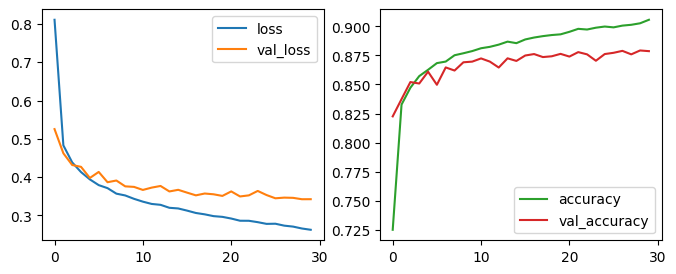

In [19]:
history_mlp_df = pd.DataFrame(history_mlp.history)
history_mlp_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [20]:
test_loss, test_acc = model_mlp.evaluate(X_test_mlp, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

304/313 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8732 - loss: 0.3684

2025-12-05 19:05:13.585817: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 4 bytes spill stores, 4 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8715 - loss: 0.3710
Test accuracy: 87.15 %


In [21]:
preds_mlp = model_mlp.predict(X_test_mlp)
preds_mlp = np.argmax(preds_mlp, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [22]:
print(classification_report(test_labels, preds_mlp,
                            target_names=class_names.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.81      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.80      0.77      0.78      1000
       Dress       0.84      0.90      0.87      1000
        Coat       0.81      0.77      0.79      1000
      Sandal       0.97      0.94      0.96      1000
       Shirt       0.67      0.70      0.68      1000
     Sneaker       0.93      0.94      0.94      1000
         Bag       0.94      0.97      0.95      1000
  Ankle boot       0.94      0.96      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### CNN

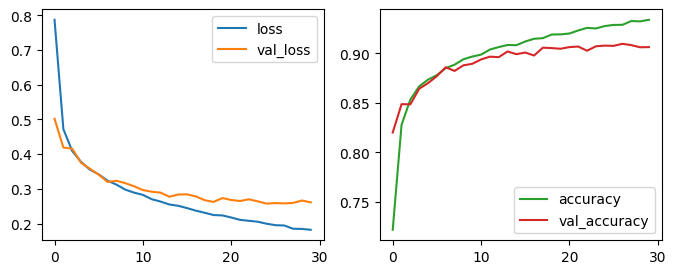

In [23]:
history_cnn_df = pd.DataFrame(history_cnn.history)
history_cnn_df[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.show()

In [24]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

2025-12-05 19:05:27.924710: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads



312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9029 - loss: 0.2786

2025-12-05 19:05:32.090735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_67', 4 bytes spill stores, 4 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9024 - loss: 0.2725
Test accuracy: 90.24 %


In [25]:
preds_cnn = model_cnn.predict(X_test_cnn)
preds_cnn = np.argmax(preds_cnn, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [26]:
print(classification_report(test_labels, preds_cnn,
                            target_names=class_names.values()))

              precision    recall  f1-score   support

 T-shirt/top       0.88      0.80      0.84      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.84      0.85      1000
       Dress       0.86      0.95      0.90      1000
        Coat       0.83      0.87      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.75      0.71      0.73      1000
     Sneaker       0.94      0.97      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## 5- Save Model and History

In [27]:
model_mlp.save('model_mlp.keras')
model_cnn.save('model_cnn.keras')
history_mlp_df.to_csv('history_mlp.csv', index=False)
history_cnn_df.to_csv('history_cnn.csv', index=False)

---

## 6- Fine-tuning

In [28]:
from keras.saving import load_model
from keras import optimizers

In [29]:
model_mlp_loaded = load_model('model_mlp.keras')
model_cnn_loaded = load_model('model_cnn.keras')

In [30]:
model_mlp_loaded.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                         loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

In [31]:
history_mlp_ext = model_mlp.fit(X_train_mlp, y_train_mlp,
                                epochs=20,
                                batch_size=256,
                                validation_data=(X_val_mlp, y_val_mlp))

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9059 - loss: 0.2606 - val_accuracy: 0.8753 - val_loss: 0.3539
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9049 - loss: 0.2630 - val_accuracy: 0.8702 - val_loss: 0.3663
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9057 - loss: 0.2593 - val_accuracy: 0.8797 - val_loss: 0.3493
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9081 - loss: 0.2553 - val_accuracy: 0.8817 - val_loss: 0.3433
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9086 - loss: 0.2496 - val_accuracy: 0.8784 - val_loss: 0.3507
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9086 - loss: 0.2503 - val_accuracy: 0.8763 - val_loss: 0.3553
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9087 - loss: 0.2499 - val_accuracy: 0.8811 - val_loss: 0.3420
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9094 - loss: 0.2477 - val_accu

In [32]:
model_cnn_loaded.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                         loss="sparse_categorical_crossentropy",
                         metrics=['accuracy'])

In [33]:
history_cnn_ext = model_cnn.fit(X_train_cnn, y_train_cnn,
                                epochs=20,
                                batch_size=256,
                                validation_data=(X_val_cnn, y_val_cnn))

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9364 - loss: 0.1758 - val_accuracy: 0.9093 - val_loss: 0.2609
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9381 - loss: 0.1726 - val_accuracy: 0.9060 - val_loss: 0.2600
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9366 - loss: 0.1724 - val_accuracy: 0.9053 - val_loss: 0.2660
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9387 - loss: 0.1688 - val_accuracy: 0.9048 - val_loss: 0.2661
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9405 - loss: 0.1638 - val_accuracy: 0.9082 - val_loss: 0.2599
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9415 - loss: 0.1614 - val_accuracy: 0.9027 - val_loss: 0.2855
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9425 - loss: 0.1586 - val_accuracy: 0.9038 - val_loss: 0.2766
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9435 - loss: 0.1561 - val_accu

In [34]:
history_mlp_prev = pd.read_csv('history_mlp.csv')
history_cnn_prev = pd.read_csv('history_cnn.csv')

history_mlp_new = pd.DataFrame(history_mlp_ext.history)
history_cnn_new = pd.DataFrame(history_cnn_ext.history)

history_mlp_full = pd.concat([history_mlp_prev, history_mlp_new],
                             ignore_index=True)
history_cnn_full = pd.concat([history_cnn_prev, history_cnn_new],
                             ignore_index=True)

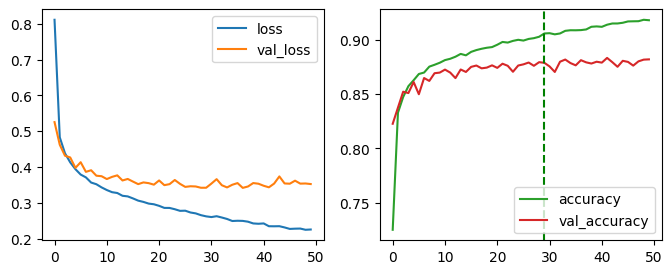

In [35]:
history_mlp_full[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.axvline(x=29, color='g', linestyle='--')
plt.show()

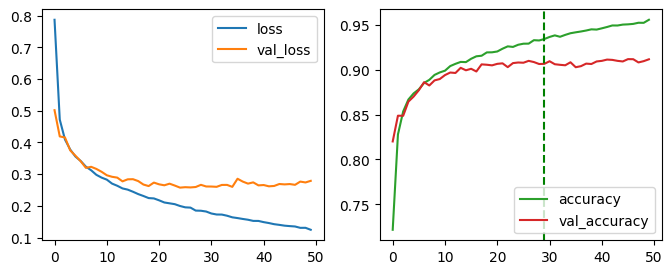

In [36]:
history_cnn_full[['loss', 'val_loss', 'accuracy', 'val_accuracy']].plot(
    subplots=(('loss', 'val_loss'), ('accuracy', 'val_accuracy')),
    layout=(1, 2),
    figsize=(8, 3))
plt.axvline(x=29, color='g', linestyle='--')
plt.show()

In [37]:
test_loss, test_acc = model_mlp_loaded.evaluate(X_test_mlp, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8715 - loss: 0.3710
Test accuracy: 87.15 %


In [38]:
test_loss, test_acc = model_cnn_loaded.evaluate(X_test_cnn, test_labels)
print(f'Test accuracy: {test_acc*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9024 - loss: 0.2725
Test accuracy: 90.24 %
